# 全人類がわかるディープラーニング Day3演習

## 概要

本演習では深層学習の基礎である多層パーセプトロンによる学習を穴埋め形式で実装します。なお、予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。
演習問題文は<font color="Red">赤字</font>です。このファイルは必ず最後までコードをすべて実行し、「最後までコードが実行可能」・「学習結果の出力がある」・「学習が成功している」の３つを満たした状態で提出してください。

また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：4~8時間

## ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
# 乱数シードを指定
np.random.seed(seed=0)

In [3]:
if os.path.exists('mnist_784'):
    with open('mnist_784','rb') as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml('mnist_784')
    with open('mnist_784', 'wb') as f:
        pickle.dump(mnist, f)
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2)

# ラベルデータをint型にし、one-hot-vectorに変換します
t_train = np.eye(10)[t_train.astype("int")]
t_test = np.eye(10)[t_test.astype("int")]

## データの説明

mnist と呼ばれる手書き数字の認識問題である。

データは 784 次元の配列となっています。

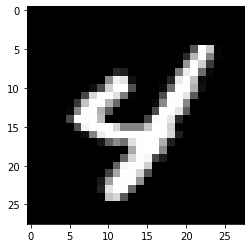

label:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


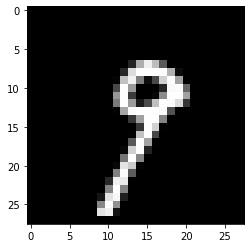

label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


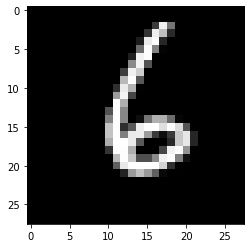

label:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


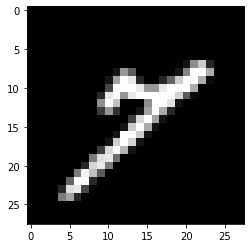

label:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


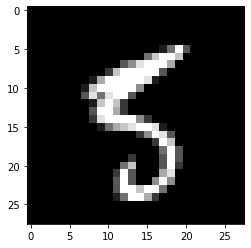

label:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [7]:
# データを5つ表示
for i in range(5):
    plt.gray()
    plt.imshow(x_train[i].reshape((28,28)))
    plt.show()
    print("label: ", t_train[i])


## Optimizer の実装

### 確率的勾配降下法

1-1. <font color="Red">確率的勾配降下法を用いたOptimizerのクラス SGD を完成させてください。</font>


In [4]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]###### 問1-1 ######

### Adam

1-2. <font color="Red">Adamを用いたOptimizerのクラス Adam を完成させてください。</font>



In [5]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key]+(1-self.beta1)*grads[key]###### 問1-2-1 ######
            self.v[key] = self.beta2*self.v[key]+(1-self.beta2)*grads[key]**2###### 問1-2-2 ######
            m_unbias = self.m[key] / (1-self.beta1**self.iter)###### 問1-2-3 ######
            v_unbias = self.v[key] / (1-self.beta2**self.iter)###### 問1-2-4 ######
            params[key] -= self.lr * m_unbias / (np.sqrt(v_unbias) + 1e-7)

## コスト関数

多クラス分類問題なので、クロスエントロピーをコスト関数して用います。

In [6]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


In [7]:
def softmax(x):
    x = x.T
    _x = x - np.max(x, axis=0)
    _x = np.exp(_x) / np.sum(np.exp(_x), axis=0)
    return _x.T

## ネットワークの実装

まずはバッチ正規化を入れない普通の三層ニューラルネットワークを実装します。問題にはなっていませんが、day1の復習も兼ねてコードを読み理解しておいてください。

In [8]:
class mnistMultiLayerNet:
    """
    layer0: 784 次元の入力
    ↓ w1, b1 で線形結合
    ↓ relu で活性化
    layer1: 100 次元の隠れ層
    ↓ w2, b2 で線形結合
    ↓ relu で活性化
    layer2: 100 次元の隠れ層
    ↓ w3, b3 で線形結合
    ↓ relu で活性化
    layer3: 100 次元の隠れ層
    ↓ w4, b4 で線形結合
    ↓ relu で活性化
    layer4: 100 次元の隠れ層
    ↓ w5, b5 で線形結合
    layer5: 10 次元の出力層
    """
    def __init__(self):
        self.input_size = 784
        self.output_size = 10
        self.hidden_size_list = [100, 100, 100, 100]
        self.all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        self.hidden_layer_num = len(self.hidden_size_list)
        self.weight_decay_lambda =0
        self.params = {}
        self.layers = {}
        self.grads = {}

        # 重みとバイアスの初期化
        for idx in range(1, len(self.all_size_list)):
            self.params['w' + str(idx)] = np.random.randn(self.all_size_list[idx-1], self.all_size_list[idx]) * 0.085
            self.params['b' + str(idx)] = np.zeros(self.all_size_list[idx], dtype=float)

        
    def forward(self, x):
        relu = lambda x : np.maximum(0, x)  # 活性化関数として ReLU を使用
        self.layers['layer0'] = x
        for idx in range(1, len(self.all_size_list) - 1):
            w = self.params['w' + str(idx)]
            b = self.params['b' + str(idx)]
            x = self.layers['layer' + str(idx - 1)]
            self.layers['layer' + str(idx)] = relu(np.dot(x, w) + b)
        idx = len(self.all_size_list) - 1
        w = self.params['w' + str(idx)]
        b = self.params['b' + str(idx)]
        x = self.layers['layer' + str(idx - 1)]
        self.layers['layer' + str(idx)] = softmax(np.dot(x, w) + b)
        
        return self.layers['layer' + str(idx)]
        

    def loss(self, y, t):
        return cross_entropy_error(y, t)
    
    def backward(self, t, y):
        delta = (y - t) / t.shape[0]
        self.grads['b5'] = np.sum(delta, axis=0)
        self.grads['w5'] = np.dot(self.layers['layer4'].transpose(), delta)
        # 誤差逆伝播
        for idx in range(4, 0, -1):
            delta = np.dot(delta, self.params['w' + str(idx + 1)].transpose())
            delta = delta *  (self.layers['layer' + str(idx)] > 0)
            self.grads['b' + str(idx)] = np.sum(delta, axis=0)
            self.grads['w' + str(idx)] = np.dot(self.layers['layer'+str(idx - 1)].transpose(), delta)
        return self.grads


## バッチ正規化を用いるネットワーク

各層について、重みを掛けて足し合わせた後バッチ正規化を行う。

2. <font color="Red">バッチ正規化を用いたニューラルネットワークを完成させてください。</font>

  バッチ正規化の順伝播は以下の式に従って実装します。
  
  - （訓練時のみ）まずは計算しているミニバッチについて、平均と分散を求めます。各次元について、全データを通じた平均・分散を計算するため、平均・分散を計算する軸にご注意ください。

  - （訓練時のみ）テスト時に使用するために、訓練データ全体での平均を推定します。モーメンタム $m$ を用いて今までの平均 $\mu_{old} $ を計算しているミニバッチの平均 $\mu$ の方向に移動させ、新しい平均$\mu_{new} $を求めます。
  $$
  \mu_{new} = m \mu_{old} + ( 1 - m)\mu
  $$

  - （訓練時のみ）同様に今までの分散 $\sigma_{old} ^ 2$ を計算しているミニバッチの平均 $\sigma^2$の方向に移動させ、 新しい分散$\sigma_{new}^2$ を求めます。
  $$
  \sigma_{new}^2 = m \sigma_{old}^2 + ( 1 - m)\sigma^2
  $$

  - 求めた平均 $\mu$ と分散 $\sigma^2$ を用いて、入力 $x$ を正規化した値 $x_n$ を求めます。分散$\sigma^2$から標準偏差 $\sigma$ を求めるときに、アンダーフローを避けるために 10e-7 ($10 \times 10 ^ {-7}$) を足してから平方根を取っています。
  テスト時には、移動平均により推定した訓練データ全体での平均・分散を使用します。
  $$
  \sigma = \sqrt{\sigma ^ 2 + 10 \times 10 ^ {-7}} 
  $$
  $$
  x_n = (x - \mu) / \sigma
  $$

   - 正規化した値 $x_n$に対して $\gamma$ を用いて変倍し、$\beta$ を用いて移動を行い、活性化関数に渡す出力 $y$ を求めます。
   $$
   y = \gamma x_n + \beta
   $$
 
   バッチ正規化の誤差逆伝播は以下の式に従って実装します。
   
   - 直前まで逆伝播してきた$1, 2, \dots , N$ 番目(Nはバッチサイズ)の出力データ$y_k$による勾配 $\frac{\partial L}{\partial y_k}$を用いて $\gamma$ と$\beta$による勾配を計算します。 $x_{nk}$ はミニバッチの中のk番目の入力データを正規化した後の値を表します。
   $$
   \begin{eqnarray} 
   \frac{\partial L}{\partial \gamma} & = & \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial \gamma} = \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} x_{nk} \\ 
\frac{\partial L}{\partial \beta} & = & \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} \frac{\partial y_k}{\partial \beta} =  \sum_{k=1}^{N} \frac{\partial L}{\partial y_k} 
\end{eqnarray}
   $$
   
   - $1, 2, \dots , N$ 番目の入力データ$x_k$による勾配 $\frac{\partial L}{\partial x_k}$を計算します（コードでは高速化のため少々異なった計算をしています）。
   
   $$
  \begin{equation} 
  \frac{\partial L}{\partial x_k} 
  = \frac{\gamma}{\sigma} \Bigg[ \frac{\partial L}{\partial y_k} 
  - \frac{1}{N} \bigg[ \frac{\partial L}{\partial \beta} + x_{nk} \frac{\partial L}{\partial \gamma} \bigg] \Bigg] 
  \end{equation}
  $$

In [9]:
class mnistMultiLayerBatchNet:
    """
    layer0: 784 次元の入力
    ↓ w1, b1 で線形結合
    ↓バッチ正規化 gamma1倍しbeta1だけずらす
    ↓ relu で活性化
    layer1: 100 次元の隠れ層
    ↓ w2, b2 で線形結合
    ↓バッチ正規化 gamma2倍しbeta2だけずらす
    ↓ relu で活性化
    layer2: 100 次元の隠れ層
    ↓ w3, b3 で線形結合
    ↓バッチ正規化 gamma3倍しbeta3だけずらす
    ↓ relu で活性化
    layer3: 100 次元の隠れ層
    ↓ w4, b4 で線形結合
    ↓バッチ正規化 gamma4倍しbeta4だけずらす
    ↓ relu で活性化
    layer4: 100 次元の隠れ層
    ↓ w5, b5 で線形結合
    layer5: 10 次元の出力層
    """
    def __init__(self):
        self.input_size = 784
        self.output_size = 10
        self.hidden_size_list = [100, 100, 100, 100]
        self.all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        self.hidden_layer_num = len(self.hidden_size_list)
        self.weight_decay_lambda =0
        self.params = {}
        self.layers = {}
        self.grads = {}
        self.norms = {}
        self.momentum = 0.9

        # パラメータの初期化
        for idx in range(1, len(self.all_size_list)):
            # 線形結合層のパラメータ
            self.params['w' + str(idx)] = np.random.randn(self.all_size_list[idx-1], self.all_size_list[idx]) * 0.085
            self.params['b' + str(idx)] = np.zeros(self.all_size_list[idx], dtype=float)
            
            # バッチ正規化でシフトさせるときに用いるγとβを更新するパラメータとし初期化
            # mu と sigma は実行時の平均と分散
            if idx != len(self.all_size_list) - 1:
                self.params['gamma' + str(idx)] = np.ones(self.all_size_list[idx])
                self.params['beta' + str(idx)] = np.zeros(self.all_size_list[idx])
                self.norms['mu' + str(idx)] = None
                self.norms['var' + str(idx)] = None
        
    def forward(self, x, train_flg=False):
        relu = lambda x : np.maximum(0, x)  # 活性化関数として ReLU を使用
        self.layers['layer0'] = x
        for idx in range(1, len(self.all_size_list) - 1):
            # 線形結合層
            w = self.params['w' + str(idx)]
            b = self.params['b' + str(idx)]
            x = self.layers['layer' + str(idx - 1)]
            x = np.dot(x, w) + b
            
            # バッチ正規化
            # 平均と分散の初期化
            if self.norms['mu' + str(idx)] is None:
                N, D = x.shape
                self.norms['mu' + str(idx)] = np.zeros(D)
                self.norms['var' + str(idx)] = np.zeros(D)
            if train_flg:
                mu = x.mean(axis=0)###### 問2.1 ######          # 今回のミニバッチの平均
                xc = x - mu                   # 今回のミニバッチの平均との差分
                var = np.mean(xc**2,axis=0)###### 問2.2 ######  # 今回のミニバッチの分散
                std = np.sqrt(var + 10e-7)    # 今回のミニバッチの標準偏差
                xn = xc / std                 # 正規化

                # 全体の平均と分散を移動平均により求める
                self.norms['mu' + str(idx)] = self.momentum*self.norms['mu'+str(idx)]+(1-self.momentum)*mu###### 問2.3 ######
                self.norms['var' + str(idx)] = self.momentum*self.norms['var'+str(idx)]+(1-self.momentum)*var###### 問2.4 ######
                
                # 誤差逆伝播で使う中間データ
                self.norms['xc' + str(idx)] = xc
                self.norms['xn' + str(idx)] = xn
                self.norms['std' + str(idx)] = std
                self.norms['size' + str(idx)] = x.shape[0]
            else:
                # テスト時は全体の平均と分散を使って正規化する
                xc = x-self.norms['mu'+str(idx)]###### 問2.5 ######
                xn = xc/((np.sqrt(self.norms['var'+str(idx)]+10e-7)))###### 問2.6 ######
                
            # バッチ正規化でシフトさせる
            shifted = self.params['gamma' + str(idx)]* xn + self.params['beta' + str(idx)]###### 問2.7 ######
            
            # relu を使って活性化
            self.layers['layer' + str(idx)] = relu(shifted)

        # 出力層
        idx = len(self.all_size_list) - 1
        w = self.params['w' + str(idx)]
        b = self.params['b' + str(idx)]
        x = self.layers['layer' + str(idx - 1)]
        self.layers['layer' + str(idx)] = softmax(np.dot(x, w) + b)
        
        return self.layers['layer' + str(idx)]
        

    def loss(self, y, t):
        return cross_entropy_error(y, t)
    
    def backward(self, t, y):
        # 出力層における誤差の勾配（クロスエントロピー関数の勾配）
        delta = (y - t) / t.shape[0]
        
        # 出力層手前の線形結合層における勾配の逆伝播
        self.grads['b5'] = np.sum(delta, axis=0)
        self.grads['w5'] = np.dot(self.layers['layer4'].transpose(), delta)
        
        # 誤差逆伝播
        for idx in range(4, 0, -1):
            delta = np.dot(delta, self.params['w' + str(idx + 1)].transpose())
            
            # relu の微分
            delta = delta *  (self.layers['layer' + str(idx)] > 0)
            
            # バッチ正規化における勾配の逆伝播
            self.grads['beta' + str(idx)] = delta.sum(axis=0)###### 問2.8 ######
            self.grads['gamma' + str(idx)] = np.sum(self.norms['xn'+str(idx)]*delta,axis=0)###### 問2.9 ######
            dxn = self.params['gamma' + str(idx)] * delta
            dxc = dxn / self.norms['std' + str(idx)]
            dstd = -np.sum((dxn * self.norms['xc' + str(idx)]) / (self.norms['std' + str(idx)] * self.norms['std' + str(idx)]), axis=0)
            dvar = 0.5 * dstd / self.norms['std' + str(idx)]
            dxc += (2.0 / self.norms['size' + str(idx)]) * self.norms['xc' + str(idx)] * dvar
            dmu = np.sum(dxc, axis=0)
            delta = dxc - dmu / self.norms['size' + str(idx)]
            
            # 線形結合層における勾配の逆伝播
            self.grads['b' + str(idx)] = np.sum(delta, axis=0)
            self.grads['w' + str(idx)] = np.dot(self.layers['layer'+str(idx - 1)].transpose(), delta)
            
        return self.grads


## ミニバッチを用いた学習

3. <font color="Red">ミニバッチサイズ128に分割して学習させるように以下のプログラムを完成させてください。</font>
 - xとtの対応を保ったままシャッフルさせたのち、バッチサイズ分だけデータを取り出します。
 - ヒント: numpy.random.permutation を用いることで、データのインデックスをシャッフルした配列を用意することで、シャッフルインデックス配列permに対して、前からバッチサイズずつインデックスを切り出せばミニバッチの抽出が行えます。
 - また、学習用のコードは実行に時間がかかります。完了するまで5~10分ほどを要しますのでご注意ください。

In [10]:
bn = mnistMultiLayerBatchNet()
nobn = mnistMultiLayerNet()
adambn = mnistMultiLayerBatchNet()
adamnobn = mnistMultiLayerNet()

bn_acc_list = []
nobn_acc_list = []
adambn_acc_list = []
adamnobn_acc_list = []

sgd = SGD(lr = 0.01)
adam = Adam(lr=0.01)

# ミニバッチアルゴリズム
batch_size = 128

In [11]:
for epoch in range(20):
    # ランダムにミニバッチへ分割するために、インデックスをランダムに並び替える
    perm = np.random.permutation(len(x_train))###### 問3.1 ######
    
    # batch_size ごとにデータを読み込んで学習させる
    for idx in np.arange(0,len(perm),batch_size):###### 問3.2 ######:
        x = x_train[perm[idx:idx+batch_size]]###### 問3.3 ######
        t = t_train[perm[idx:idx+batch_size]]###### 問3.4 ######
        
        y = bn.forward(x, train_flg=True)
        grads = bn.backward(t, y)
        sgd.update(bn.params,grads)
        
        y = adambn.forward(x, train_flg=True)
        grads = adambn.backward(t, y)
        adam.update(adambn.params,grads)
        
        y = nobn.forward(x)
        grads = nobn.backward(t,y)
        sgd.update(nobn.params, grads)
        
        y = adamnobn.forward(x)
        grads = adamnobn.backward(t, y)
        adam.update(adamnobn.params,grads)

    y_test = bn.forward(x_test)
    bn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = nobn.forward(x_test)
    nobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = adambn.forward(x_test)
    adambn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())
    y_test = adamnobn.forward(x_test)
    adamnobn_acc_list.append((y_test.argmax(axis=1) == t_test.argmax(axis=1)).mean())

    print(f'EPOCH {epoch + 1} | NoBatch ACCURACY (SGD) {nobn_acc_list[-1]:.2%} | Batch ACCURACY (SGD){bn_acc_list[-1]:.2%} | NoBatch ACCURACY (Adam){adamnobn_acc_list[-1]:.2%} | Batch ACCURACY (Adam) {adambn_acc_list[-1]:.2%}')

EPOCH 1 | NoBatch ACCURACY (SGD) 84.92% | Batch ACCURACY (SGD)84.83% | NoBatch ACCURACY (Adam)92.09% | Batch ACCURACY (Adam) 94.61%
EPOCH 2 | NoBatch ACCURACY (SGD) 89.63% | Batch ACCURACY (SGD)89.61% | NoBatch ACCURACY (Adam)93.97% | Batch ACCURACY (Adam) 95.37%
EPOCH 3 | NoBatch ACCURACY (SGD) 91.01% | Batch ACCURACY (SGD)91.44% | NoBatch ACCURACY (Adam)94.79% | Batch ACCURACY (Adam) 96.48%
EPOCH 4 | NoBatch ACCURACY (SGD) 92.16% | Batch ACCURACY (SGD)92.63% | NoBatch ACCURACY (Adam)94.30% | Batch ACCURACY (Adam) 96.62%
EPOCH 5 | NoBatch ACCURACY (SGD) 92.55% | Batch ACCURACY (SGD)93.35% | NoBatch ACCURACY (Adam)90.11% | Batch ACCURACY (Adam) 96.34%
EPOCH 6 | NoBatch ACCURACY (SGD) 93.41% | Batch ACCURACY (SGD)94.03% | NoBatch ACCURACY (Adam)94.02% | Batch ACCURACY (Adam) 96.80%
EPOCH 7 | NoBatch ACCURACY (SGD) 93.66% | Batch ACCURACY (SGD)94.26% | NoBatch ACCURACY (Adam)94.31% | Batch ACCURACY (Adam) 96.61%
EPOCH 8 | NoBatch ACCURACY (SGD) 93.76% | Batch ACCURACY (SGD)94.59% | NoBat

## 学習結果
学習結果を可視化してみます。まずはSGDを使った学習についてのみ比較を行います。結果のグラフが以下のグラフと一致していれば学習は成功しています。<img src = "sgd.png">

学習結果からわかる通り、バッチ正規化を加えることでテスト精度が高い水準で安定させることが可能となります。

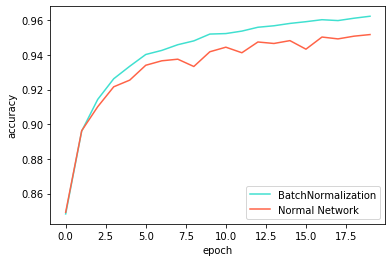

In [12]:
x = range(20)
plt.plot(x, bn_acc_list, color='turquoise')
plt.plot(x, nobn_acc_list, color='tomato')

plt.legend(['BatchNormalization', 'Normal Network'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

次にAdamで学習した場合も含めてプロットしてみましょう。結果のグラフが以下と一致していれば学習成功です。
<img src="adam.png">
Adamで学習すると、SGDよりも学習が進みやすく、高い精度が実現できていることがわかるかと思います。

また、バッチ正規化を加えないネットワークでは過学習により途中からテスト精度が急に低下していることがわかります。バッチ正規化を加えることで正則化の役割も可能となっていることが読み取れます。

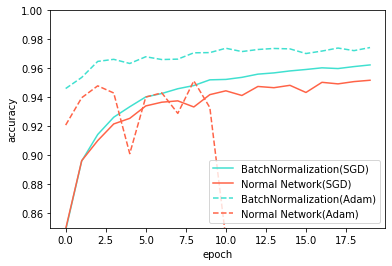

In [13]:
x = range(20)
plt.plot(x, bn_acc_list, color='turquoise', linestyle = '-')
plt.plot(x, nobn_acc_list, color='tomato', linestyle='-')
plt.plot(x, adambn_acc_list, color='turquoise', linestyle = '--')
plt.plot(x, adamnobn_acc_list, color='tomato', linestyle='--')

plt.ylim((0.85, 1))

plt.legend(['BatchNormalization(SGD)', 'Normal Network(SGD)', 'BatchNormalization(Adam)', 'Normal Network(Adam)'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()